Data Challenge 2: Yammer - A Drop in Engagement
Stephanie Gervasi
Feb. 27, 2019

#### THE PROBLEM:

You show up to work Tuesday morning, September 2, 2014. The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards (yes this really happens). 
You fire them up, and something immediately jumps out:
![test](image.png)

The chart shows the number of engaged users each week. Yammer defines engagement as having made some type of server call by interacting with the product (shown in the data as events of type “engagement”). Any point in this chart can be interpreted as “the number of users who logged at least one engagement event during the week starting on that date.”

#### THE QUESTION:

The head of product says “Can you look into this and get me a summary by this afternoon?”  

#### THE DATA:

For this challenge we have 4 sources of data (events, users, emails, rollup) that are described in more detail, by column, elsewhere. 
Important notes about the data sources: 

* 'events' * has 1 row per event, but users have >1 event. Also included in this table is the date of the event, the type of event, the location of the user, and the device used for the event.
* 'users' * has 1 row per user, and it includes the company the user belongs to, when the user's account was activated, and whether the user is in an active or pending state for starting use of the Yammer tool. Also includes the user's language.
* 'emails' * is similar to events in that there is 1 row per email event, and we also know the type/name of the email event and when it occurred.
* 'rollup' * includes start and end times and this is what was used to produce the summary image/graphic above.

#### THE HYPOTHESES/QUESTIONS:

The image above suggests that the number of server calls or engagements with Yammer per week have increased for May, June and July, but are starting to decrease in August. We don't know if this summary/aggregated change in Yammer events is due to a general or specific pattern in activity changes.

(1) Is the change in engagement trend because of a change in the number of users or because existing users are more/less active?

(2) Is the change in engagement trend a result of all users changing engagment or a subset of certain users changing their engagment?

(3) If it is the case that the same number of users (more or less) are just less or more active - are they doing more/less of the same type of engagment activities, or are they expanding or reducing the types of events that they particpate in on Yammer, and this is the reason for the trend in the aggregate plot?

In summary: Although we can't infer causation, my question is whether we can find any correlation between those with reduced activity on Yammer and any other variables available to us in the datasets?

NOTE: The question is about the 'latest activity' and this question is said to be posed September 2014. Thus, I will focus just on this period of time (May - August 2014).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the data
df_events = pd.read_csv("yammer_events.csv")
df_users=pd.read_csv("yammer_users.csv")
df_emails=pd.read_csv("yammer_emails.csv")
df_rollup=pd.read_csv("dimension_rollup_periods.csv")

Let's start by looking at the dataframes. What are the columns? What is available to us for EDA? What are some trends we can pick out right away?

In [3]:
# EVENTS:
print("The data has {0} rows and {1} columns".format(df_events.shape[0], df_events.shape[1]))
df_events.head()
df_events.info()

The data has 340832 rows and 7 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 7 columns):
user_id        340832 non-null int64
occurred_at    340832 non-null object
event_type     340832 non-null object
event_name     340832 non-null object
location       340832 non-null object
device         340832 non-null object
user_type      325255 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 18.2+ MB


In [4]:
# USERS:
print("The data has {0} rows and {1} columns".format(df_users.shape[0], df_users.shape[1]))
df_users.head()
df_users.info()

The data has 19066 rows and 6 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 6 columns):
user_id         19066 non-null int64
created_at      19066 non-null object
company_id      19066 non-null int64
language        19066 non-null object
activated_at    9381 non-null object
state           19066 non-null object
dtypes: int64(2), object(4)
memory usage: 893.8+ KB


In [5]:
# EMAILS:
print("The data has {0} rows and {1} columns".format(df_emails.shape[0], df_emails.shape[1]))
df_emails.head()
df_emails.info()

The data has 90389 rows and 4 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
user_id        90389 non-null int64
occurred_at    90389 non-null object
action         90389 non-null object
user_type      90389 non-null int64
dtypes: int64(2), object(2)
memory usage: 2.8+ MB


In [6]:
# ROLLUP:
print("The data has {0} rows and {1} columns".format(df_rollup.shape[0], df_rollup.shape[1]))
df_rollup.head()
df_rollup.info()

The data has 56002 rows and 6 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56002 entries, 0 to 56001
Data columns (total 6 columns):
period_id    56002 non-null int64
time_id      56002 non-null object
pst_start    56002 non-null object
pst_end      56002 non-null object
utc_start    56002 non-null object
utc_end      56002 non-null object
dtypes: int64(1), object(5)
memory usage: 2.6+ MB


We should transform the time columns to date-time format so that it is easier to work with and transform for additional information, like month and year.

In [7]:
import datetime

# For the EVENTS df:
df_events['occurred_at'] = pd.to_datetime(df_events['occurred_at'])
df_events['year'] = (df_events['occurred_at'].dt.year)
df_events['month'] = (df_events['occurred_at'].dt.month)
df_events['week'] = (df_events['occurred_at'].dt.week)

# For the USERS df:
## I was more interested in time w/r/t when accounts were activates (starting being used) vs. when they were created.
df_users['activated_at'] = pd.to_datetime(df_users['activated_at'])
df_users['year'] = (df_users['activated_at'].dt.year)
df_users['month'] = (df_users['activated_at'].dt.month)
df_users['week'] = (df_users['activated_at'].dt.week)
df_users['created_at'] = pd.to_datetime(df_users['created_at'])

# For the EMAILS df:
df_emails['occurred_at'] = pd.to_datetime(df_emails['occurred_at'])
df_emails['year'] = (df_emails['occurred_at'].dt.year)
df_emails['month'] = (df_emails['occurred_at'].dt.month)
df_emails['week'] = (df_emails['occurred_at'].dt.week)

# For the ROLLUP df:
#df_rollup.head()
##I'm not sure I'll use the rollup df, so I will leave it for now.

A NOTE: time in weeks, as I have formatted it here is necessarily the rollup week. It is calendar weeks (see below). This is simply for ease of quick viewing.


![weeks](image2.png)

Now we can do some EDA to start addressing the questions we posed above. 
Let's start with the first question:
(1) Is the change in engagement trend because of a change in the number of users or because existing users are more/less active?
From the question and information given in the case study, I assume that we really just want to know about what's happening in May - August 2014, and in particular, the illustrated change in users over the last month, which seems to be an overall decline. So I'll focus on that time period, exclusively.


In [8]:
# Create a grouped dataframe that is the count of users by by week for the time period we are interested in. 
# get users for 2014 only
users_2014 = df_users[df_users.year == 2014] # Note that this also gets rid of any 'pending' users who are not activated since they have NaN for year.
users_2014.head()

# get users for month 27 and on as above (May to August 2014)
users_may_aug = users_2014[users_2014.month >= 5]
users_may_aug.head()

# get users by week, and plot by language as a rough, and imperfect proxy for location. Maybe user trends vary by location.
grouped_users = users_may_aug.groupby(['week', 'language']).size().reset_index(name='number_users')
grouped_users.head()

,week,language,number_users
0,18.0,arabic,7
1,18.0,chinese,1
2,18.0,english,34
3,18.0,french,7
4,18.0,german,5


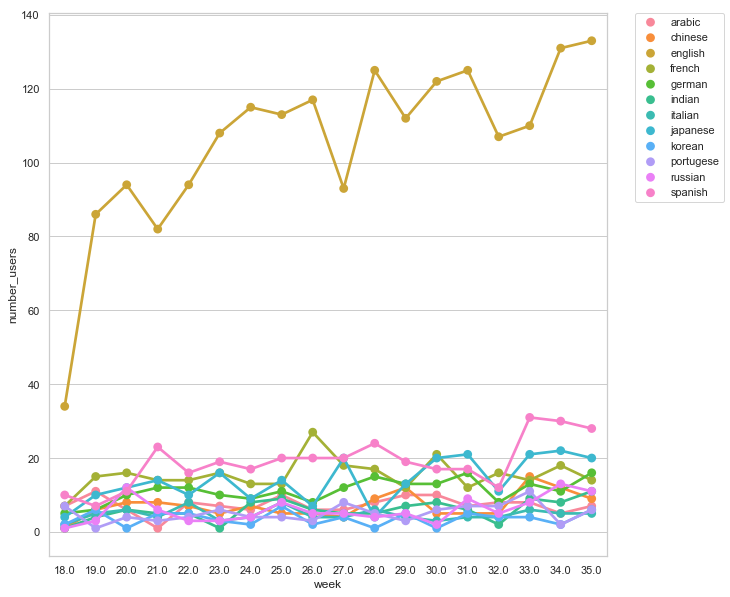

In [14]:
# Plot the summary table of counts that was generated above. 
# Remember week 31 and on represents that supposed decrease in activity that we saw on the plot given to us.

sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (10, 10)
sns.pointplot(x="week", y="number_users", hue = 'language', data=grouped_users)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# The initial plot we were given shows a kind of peak in activity just before Aug 1, which is week 31 here. 
# This plot suggests that users dip but then are increasing, overall, from week 32 on, which is not relfected in our initial plot.
# Here we might suspect that number of users is not driving the trends. Activity of users might then be more relevant.
# We also see that number of users that have english as their primary language is highest.

As a next step let's look at how engagement has changed over time. This reflects activity on Yammer, rather than absolute number of users registered on or using Yammer.


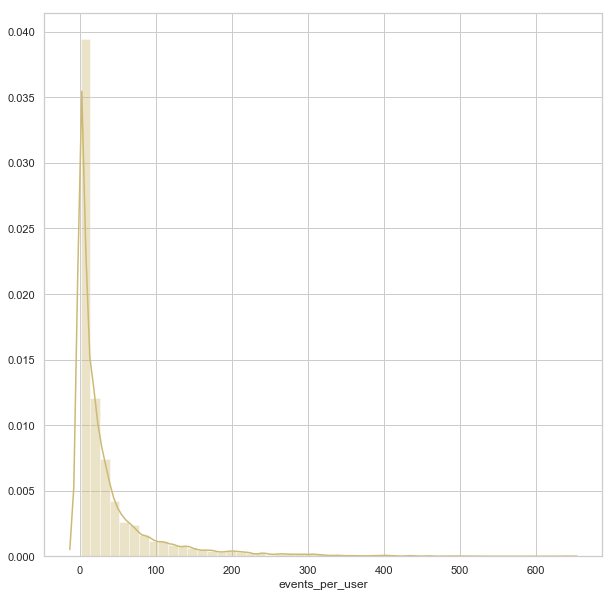

In [15]:
# First, let's just look at an overall distribution plot of user activity. Note that we only have 2014 data.
# Again we want to look at just the period that corresponds to our original data given - May - August.

may_aug_events = df_events[df_events.month >= 5]

# Group users by frequency or count of events. This tells us something about whether individual users are more homogenous or heterogeneous.
events_per_user = may_aug_events.groupby(['user_id']).size().reset_index(name='events_per_user')

sns.distplot(events_per_user['events_per_user'], rug = False, color = 'y')
# Conclude: Most users have less than 50 events between May and August 2014. 
# Later we might want to revisit and ask about the superusers with more than 100 events.

In [16]:
may_aug_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,year,month,week
0,10522,2014-05-02,engagement,login,Japan,dell inspiron notebook,3.0,2014,5,18
1,10522,2014-05-02,engagement,home_page,Japan,dell inspiron notebook,3.0,2014,5,18
2,10522,2014-05-02,engagement,like_message,Japan,dell inspiron notebook,3.0,2014,5,18
3,10522,2014-05-02,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014,5,18
4,10522,2014-05-02,engagement,search_run,Japan,dell inspiron notebook,3.0,2014,5,18


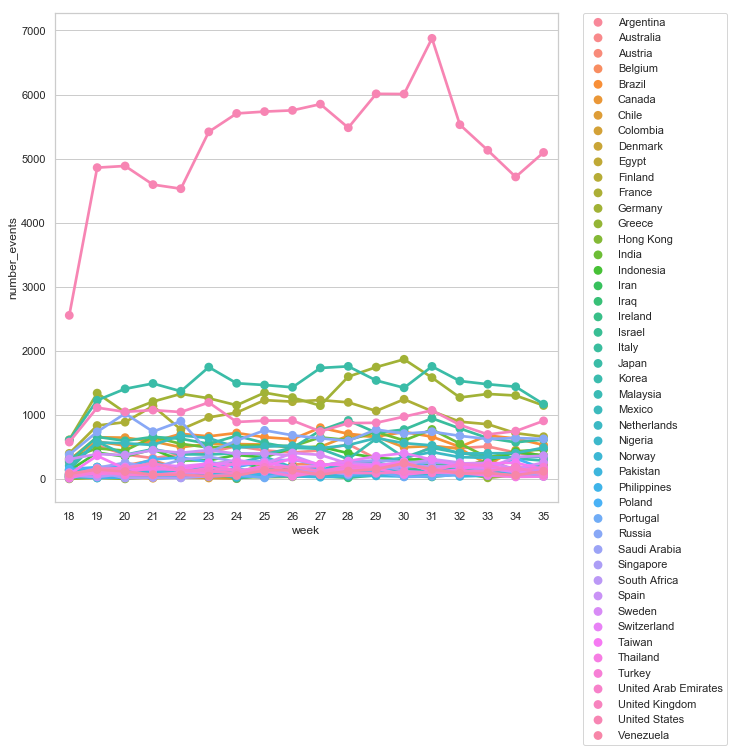

In [17]:
# Let's also consider that total events might differ by location. Let's check and see how activity varies with location.
events_per_week_by_location = may_aug_events.groupby(['location','week']).size().reset_index(name='number_events')
events_per_week_by_location.head()


sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (9, 9)
sns.pointplot(x="week", y="number_events", hue='location', data=events_per_week_by_location)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# This figure is important because it shows a similar trend from about week 31 on, which was evident in the original
# figure that our boss gave us. It looks like we are probably looking at US data. Here, we see that number of events 
# decreases from just before August to the end of the timeframe of dataset.
# We can make sure that we are looking at United States since colors overlap.

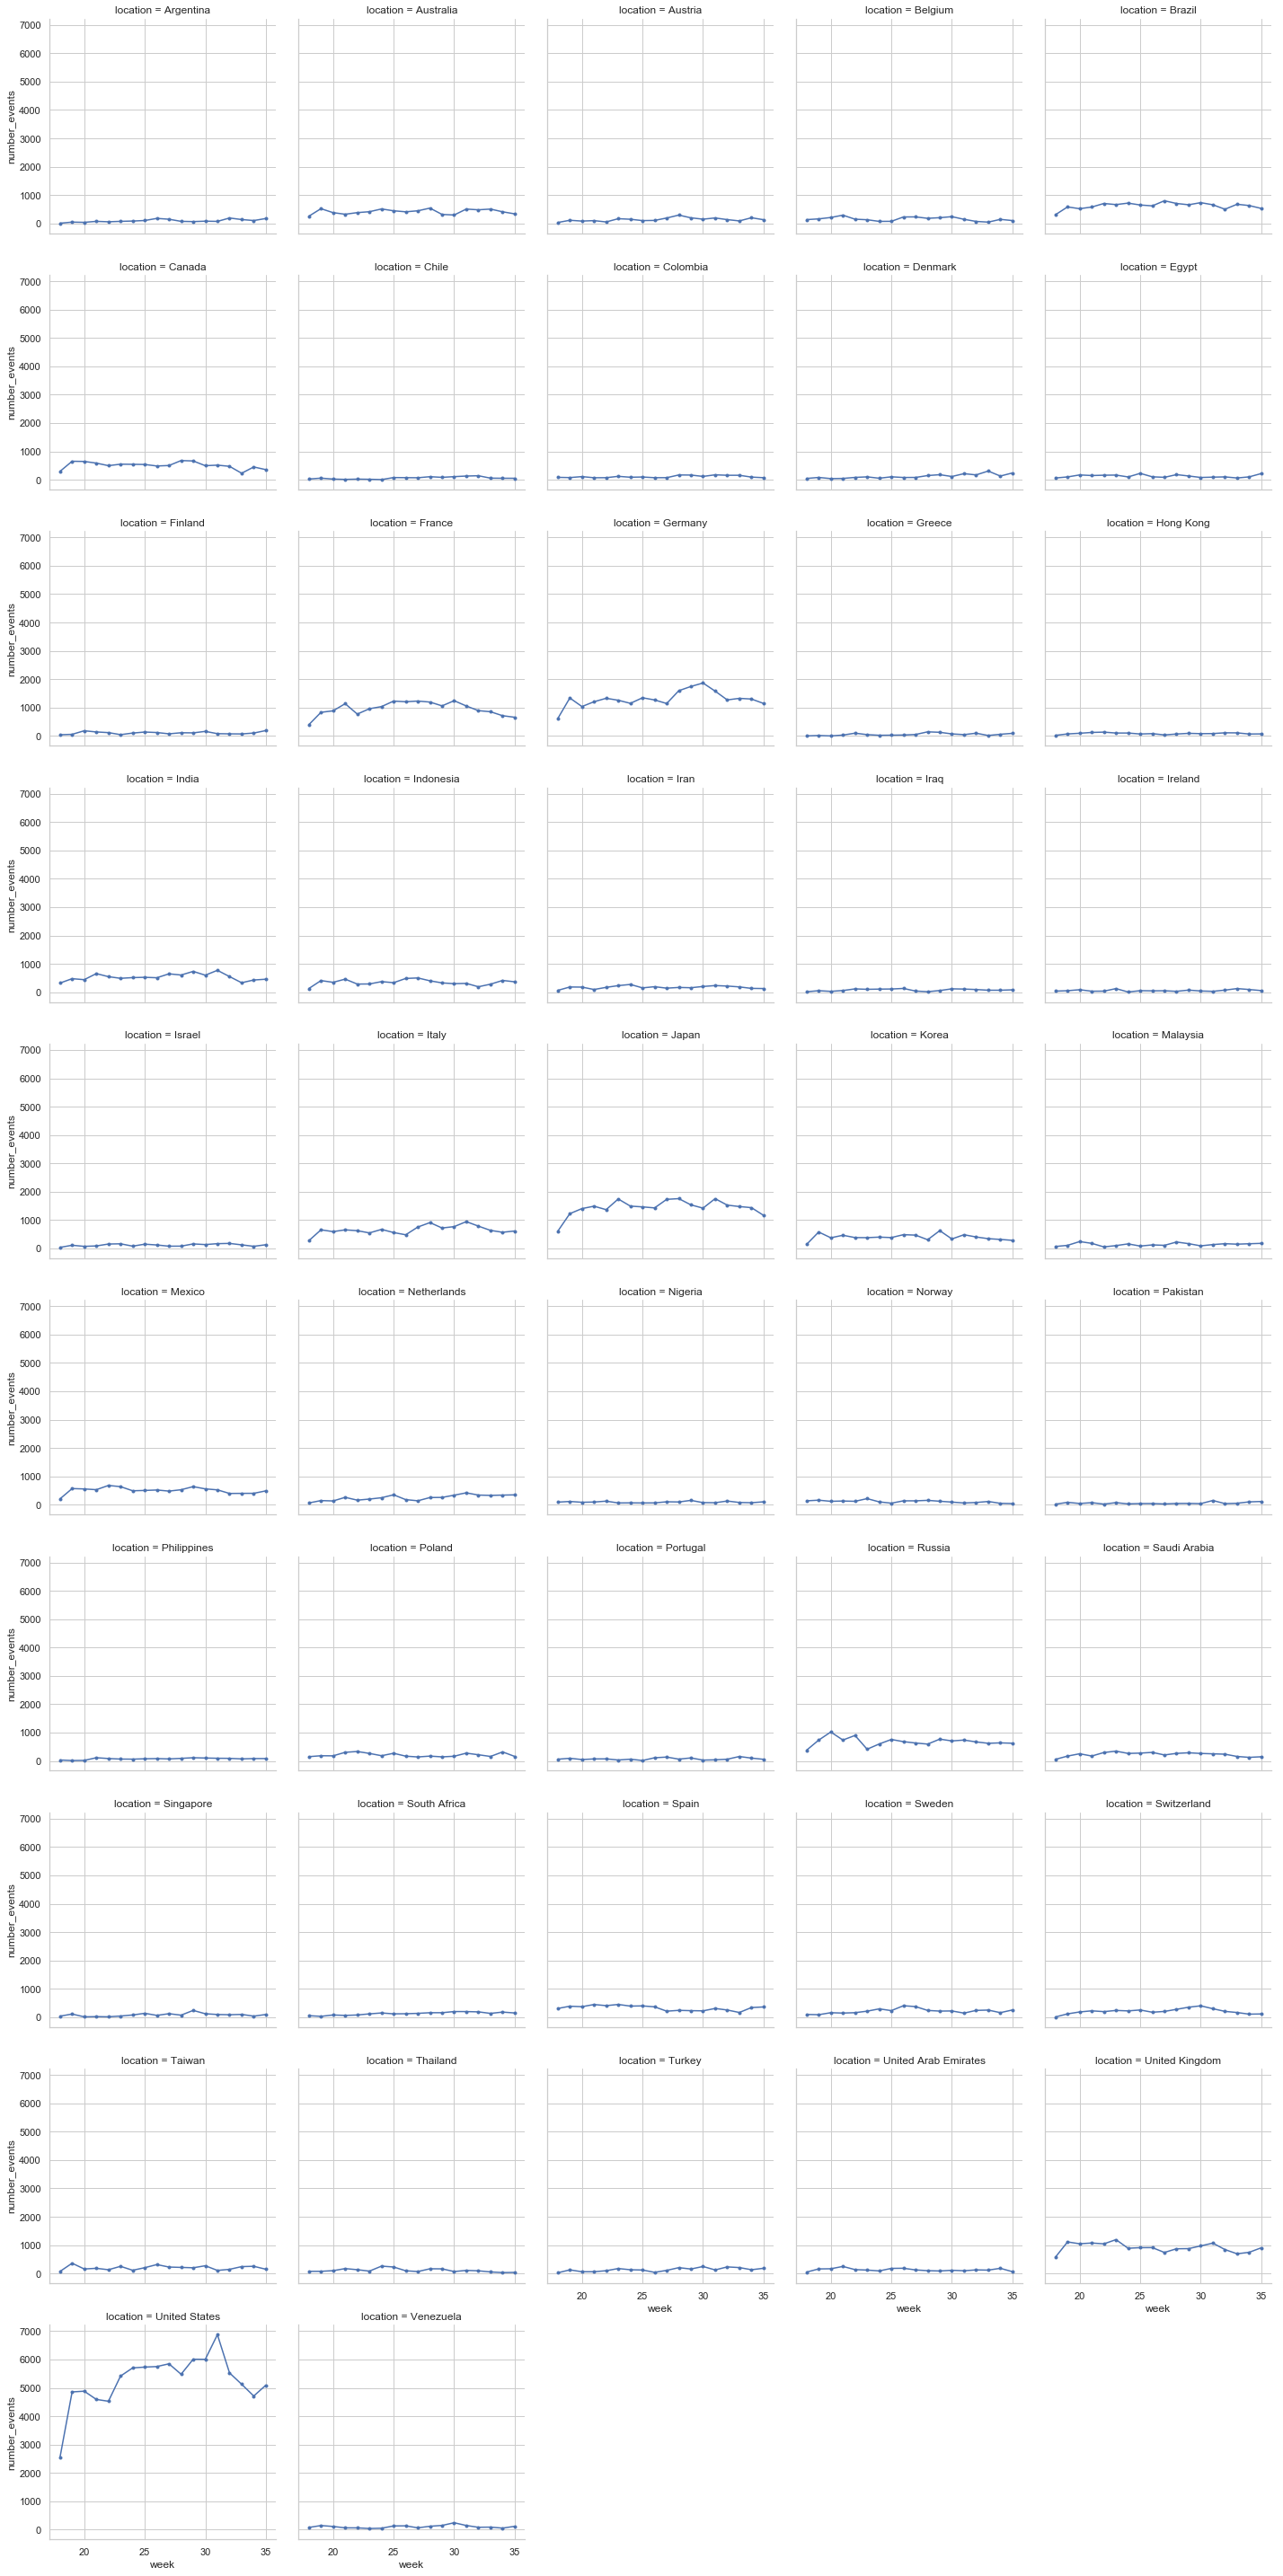

In [18]:
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)
g = sns.FacetGrid(events_per_week_by_location, col="location", col_wrap=5, height=4)
g = g.map(plt.plot, "week", "number_events", marker=".")

# The faceted plot below confirms that the United States is the top line in the previous figure.

At this point we know that 
(1) It seems like there are not fewer users, all of a sudden (overall users are increasing) but that the activity of users is changing.
(2) It appears that this dip in activity is greatest in the US. 

We have answered questions 1 and 2, above, so let's move on to question 3:
If it is the case that the same number of users (more or less) are just less or more active - are they doing more/less of the same type of engagment activities, or are they expanding or reducing the types of events that they particpate in on Yammer, and this is the reason for the trend in the aggregate plot?
    
* For this question I will focus only on the United States, where engagement changes matches what we've seen in the figure provided to us.

In [19]:
US_events = may_aug_events[may_aug_events.location == 'United States']
US_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,year,month,week
58,11194,2014-05-06,engagement,login,United States,ipad mini,2.0,2014,5,19
59,11194,2014-05-06,engagement,home_page,United States,ipad mini,2.0,2014,5,19
60,11194,2014-05-06,engagement,view_inbox,United States,ipad mini,2.0,2014,5,19
61,11194,2014-05-06,engagement,home_page,United States,ipad mini,2.0,2014,5,19
62,11194,2014-05-06,engagement,send_message,United States,ipad mini,2.0,2014,5,19


In [20]:
# Now that we know that activity levels seem to be decreasing from about week 31 on, we can look at that time, and 
# ask about how different types of events, by name, change, within the US.

US_events_wk31 = US_events[US_events.week >= 31]
US_events_wk31

event_name_grouped = US_events_wk31.groupby(['week','event_name']).size().reset_index(name='number_events')
event_name_grouped.head()

,week,event_name,number_events
0,31,complete_signup,68
1,31,create_user,134
2,31,enter_email,78
3,31,enter_info,71
4,31,home_page,1911


Let's just make sure we know what we're focusing on first, here is the overall trend in number of events on Yammer in the US from week 31 on.


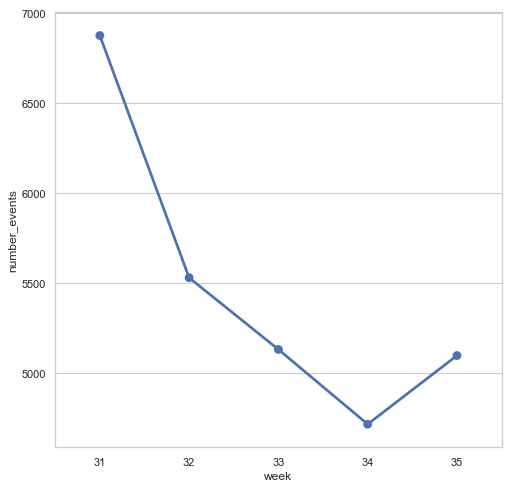

In [21]:
plt.rcParams['figure.figsize'] = (8, 8)
events_weekly = US_events_wk31.groupby(['week']).size().reset_index(name='number_events')
sns.pointplot(x="week", y="number_events", data=events_weekly)

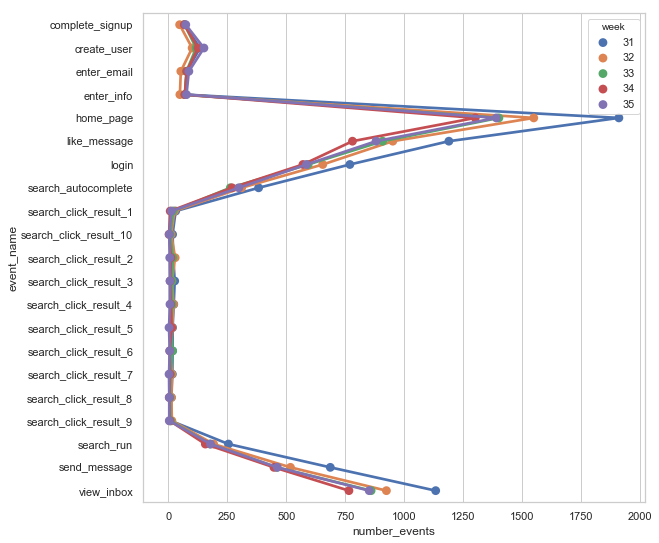

In [22]:
plt.rcParams['figure.figsize'] = (9, 9)
sns.pointplot(x="number_events", y="event_name", hue='week', data=event_name_grouped)

We can add to our conclusions above, by saying that most types of engagements or interactions with Yammer have stayed the same in the US from week 31 onward (where we saw the overall downward trend in activity) except for home page activity, which is the most frequent type of event that users are engaged in. Here, from Week 31 to week 35, we see a decrease from 2000 events to about 1300 events.
In addition, inbox views, which are the second most frequent type of event, are also down from week 31 to 35. This trend is also evident for logins. This makes me wonder if perhaps what we are seeing is just a decrease in activity because people are on vacation. We don't know what happens after August, but looking at September could reveal wither activity levels bounce back up.


Maybe we could get at some of this if we look at how the users in August are engaged with Yammer. What device are they using? Maybe they use their phone to access when they are away from the office? Maybe use of iphones to access email etc. is greater in August. Let's see.


In [23]:
device_grouped = US_events_wk31.groupby(['week','device']).size().reset_index(name='number_events')
device_grouped.head()

,week,device,number_events
0,31,acer aspire desktop,178
1,31,acer aspire notebook,142
2,31,amazon fire phone,56
3,31,asus chromebook,153
4,31,dell inspiron desktop,138


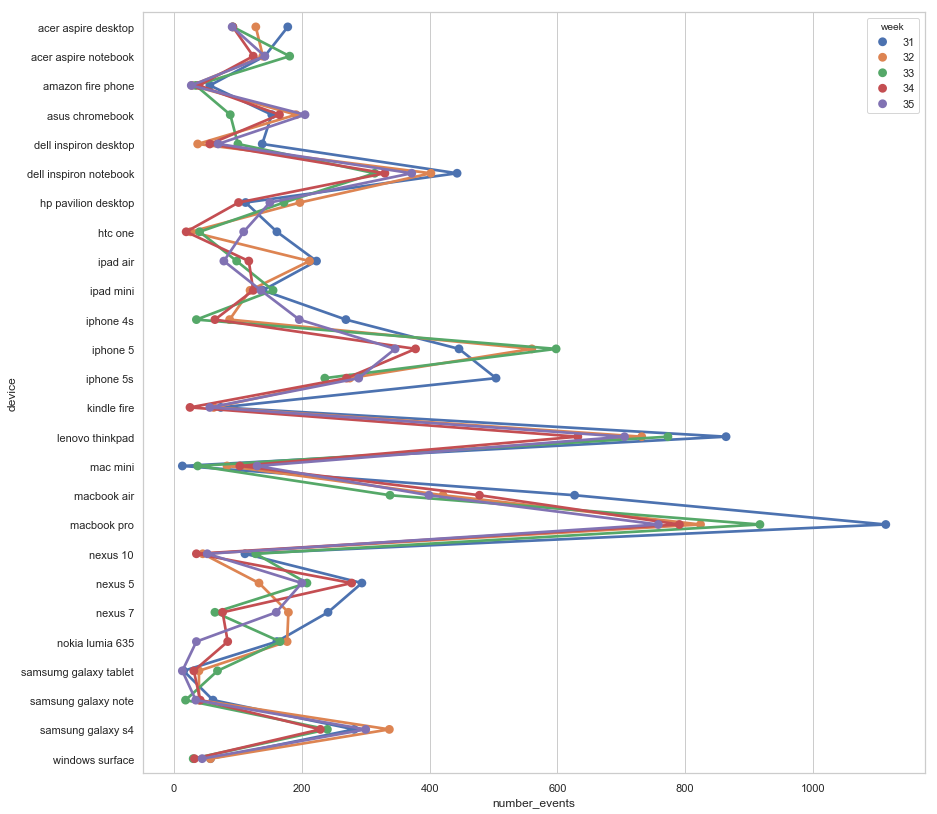

In [24]:
plt.rcParams['figure.figsize'] = (14, 14) # let's make it big so we can see all 5 months by color.
sns.pointplot(x="number_events", y="device", hue='week', data=device_grouped)

From this plot, it definitely seems like the decrease in engagement from week 31 onward is also reflected in a decrease in events logged by computers like macbook pro and lenovo thinkpad and dell inspiron.
On the other hand, some phones like the samsung galaxy s4 and the iphone 5 are logging more events a little bit later (week 32, 33).
It's hard to be sure, but maybe some people are using phones more than computers at the later months, when engagement drops.

I'd like to look at the emails DF to see if we can pick up at a finer resolution what's happening during the month of August in terms of activity.


In [25]:
df_emails.head()
#df_emails['month'].unique()
#df_emails['action'].unique() # actions can be one of 4 options: sent weekly digest, opened email, clicked through email, or sent re-engagement email.
# checked to make sure this is just 2014 and months 5-8.

,user_id,occurred_at,action,user_type,year,month,week
0,0,2014-05-06,sent_weekly_digest,1,2014,5,19
1,0,2014-05-13,sent_weekly_digest,1,2014,5,20
2,0,2014-05-20,sent_weekly_digest,1,2014,5,21
3,0,2014-05-27,sent_weekly_digest,1,2014,5,22
4,0,2014-06-03,sent_weekly_digest,1,2014,6,23


Now I'll ask about how a specific type of activity, engagement with emails, changes over time.

In [26]:
# Want to again just focus in on weeks 31 onward.
emails_31wk = df_emails[df_emails.week >=31]

action_grouped = emails_31wk.groupby(['week','action']).size().reset_index(name='actions_per_week')
action_grouped.head()

,week,action,actions_per_week
0,31,email_clickthrough,633
1,31,email_open,1386
2,31,sent_reengagement_email,230
3,31,sent_weekly_digest,3706
4,32,email_clickthrough,432


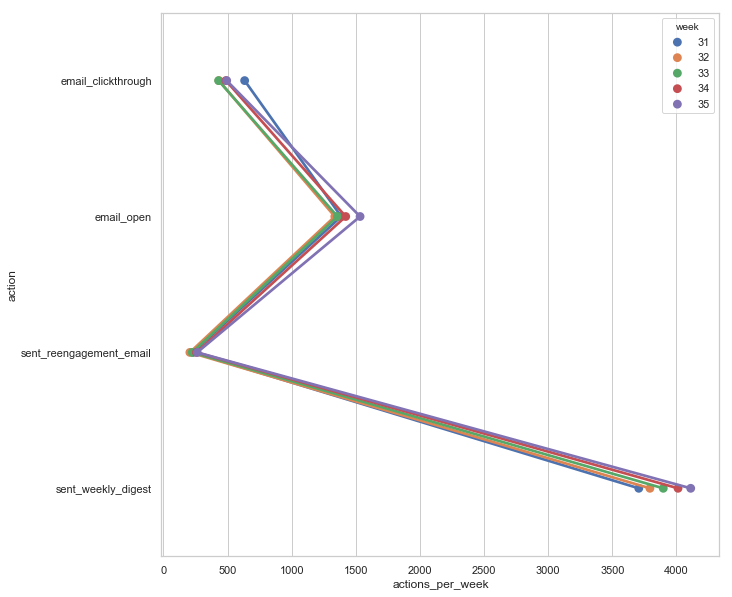

In [28]:
plt.rcParams['figure.figsize'] = (10, 10) 
sns.pointplot(x="actions_per_week", y="action", hue='week', data=action_grouped)

Here we see that for email-related activity, things like sending weekly digests have actually increased over the month of august, not decreased. But note that it's a very small overall change (for weekly digest from ~3600 to a little over 4000).
Email clickthrough dropped slightly over the month of August. Again, the magnitude of these changes seem small to number of users and overall trends in activity that we looked at above.


CONCLUSIONS

To recap: The question was "what do you think about the latest activity on the user engagement dashboards: My job is to provide a summary.


My approach was to first think about what questions I would ask to address this question about activity. In general, it looked as if engagement activity was decreasing from right before August, onward.
My initial questions before looking at the data were:

(1) Is the change in engagement trend because of a change in the number of users or because existing users are more/less active?

(2) Is the change in engagement trend a result of all users changing engagment or a subset of certain users changing their engagment?

(3) If it is the case that the same number of users (more or less) are just less or more active - are they doing more/less of the same type of engagment activities, or are they expanding or reducing the types of events that they particpate in on Yammer, and this is the reason for the trend in the aggregate plot?


Through interactions with the users, events, and emails dataframes separately, even without going to any merges of the data, it was apparent that:

(1) The change in activity/engagement with the Yammer platform does not seem to be due to a sudden decerease in users. Instead, it seems like an activity decrease was responsible for the dip.

(2) Data also suggest that the reduced engagement was likely driven by what was happening in the US, although several other countries showed slight decreases in engagement activity in August. From this point, I decided to focus on the US data.

(3) When I looked at the type of engagement with Yammer, it looked like home page interactions, inbox views, liking messages, logins, search run, search autocomplete, and sending messages were all down from just before August to the end of the month. These are daily activities someone would do at work -- so maybe this is reflecting people in the US primarily taking vacations in August, when work activity is generally slower. To investigate whether trends in email activity matched what these overall activity categories showed, I also looked at the email dataframe. Althoug the magnitude of the effects was smaller, the trends were similar. 

Since the number of users does not seem to be decreasing, but some types of activities were decreasing, and because this wasa fairly drastic and recent dip compared to previous months for which we have data, we could be looking at a temporary seasonal effect. Since it is already the end of August, I would want to see if the September data, 1 month later, reflects a rebound in activity (w/out a confounding jump in new user registration). If activity levels go back up, I would conclude that this was a phenomenon of people leaving for summer vacation and then returning to work.


APPENDIX: EXTRA EXPLORATION OF DATAFRAMES.

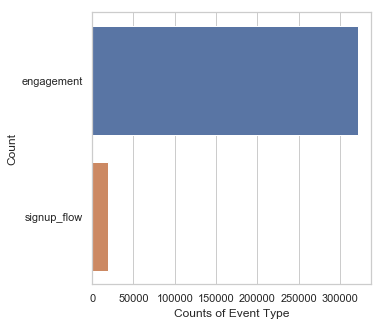

In [157]:
# What is the break down/count of events on Yammer by type?
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (5, 5)
ax = sns.countplot(y="event_type", data=df_events) 
ax.set(xlabel='Counts of Event Type', ylabel='Count')
plt.show()
# Conclude: Signup flow is just when the user is going through authentication; engagement is after authentication. 
# Here we see that most of the activity is engagement. Not surprising, but this basically tells us that people are active beyond initial authetication of their accounts.

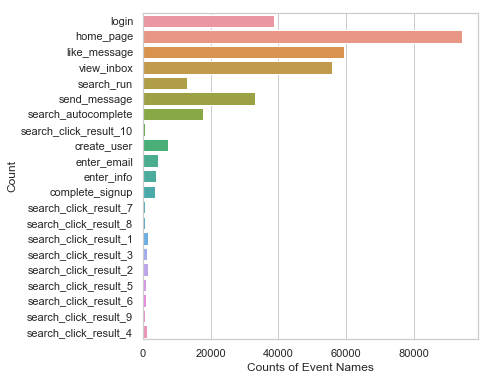

In [158]:
# What is the break down/count of events by name?
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (6, 6)
ax = sns.countplot(y="event_name", data=df_events) 
ax.set(xlabel='Counts of Event Names', ylabel='Count')
plt.show()
# Conclude: Most of the engagement from users, overall, is w/r/t the home page. Other events such as liking a message, viewing the inbox, logging in, and sending messages are also high frequency types of engagements with Yammer.
# Seems that most of engagement is potentially with email, compared to searching and clicking.

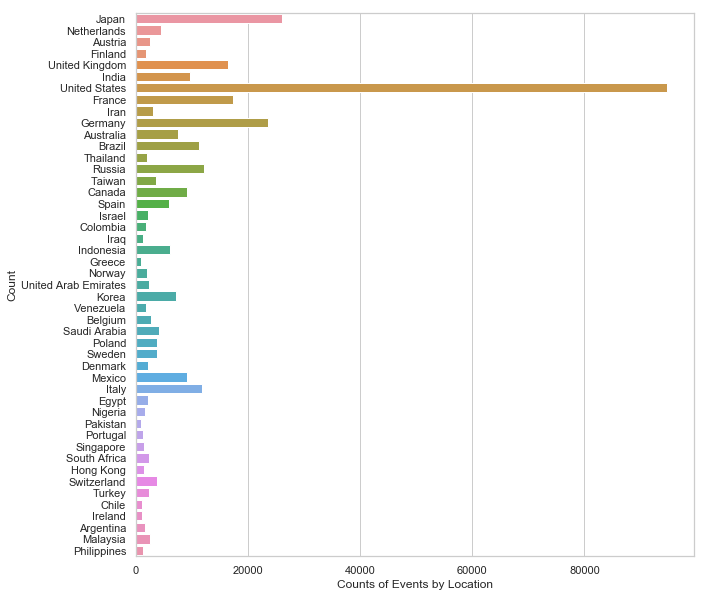

In [159]:
# What is the break down/count of events by location?
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (10.0, 10.0)
ax = sns.countplot(y="location", data=df_events) 
ax.set(xlabel='Counts of Events by Location', ylabel='Count')
plt.show()
# Conclude: Highest levels of Yammer engagement occur in the US (by several orders of magnitude)!
# We know nothing in this case study about the location, but we might go forward assuming that it is the US.

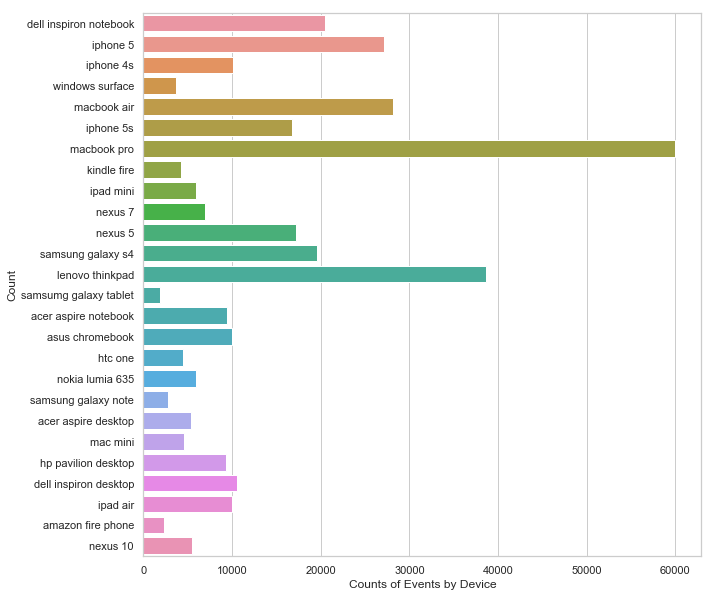

In [160]:
# What is the break down/count of events by device type. * This might indicate whether people are primarily 
# using Yammer out of work time (on their cell phones or other mobile devices) compard to at work (on computers/desktops).
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (10.0, 10.0)
ax = sns.countplot(y="device", data=df_events) 
ax.set(xlabel='Counts of Events by Device', ylabel='Count')
plt.show()
# Conclude: Macbooks and lenovo thinkpads are the most frequently used devices for logging events on Yammer. 
# Possibly, people are mostly using Yammer while at work (not accessing after hours as much).

The events dataframe could be most useful when we look at individual user activity. In this dataframe each row is an event. But we could condense this down to look at how individual users from different locations are behaving.


In [163]:
# Here we are grouping users by frequency or count of events. This tells us something about whether individual users are more homogenous or heterogeneous.
events_per_user = df_events.groupby(['user_id']).size().reset_index(name='events_per_user')
events_per_user.head()
#events_per_user.shape 
# We know there are 9760 unique users in this df.

,user_id,events_per_user
0,4,93
1,8,36
2,11,126
3,17,55
4,19,71


In [265]:
superusers_100 = events_per_user[events_per_user.events_per_user >= 100]
superusers_100.head()
#superusers_100['user_id'].nunique()
# We know that there are 944 users with more than 100 events. These users could be driving overall trends since they have extreme values.

,user_id,events_per_user
2,11,126
6,22,357
9,59,257
15,86,118
17,101,401


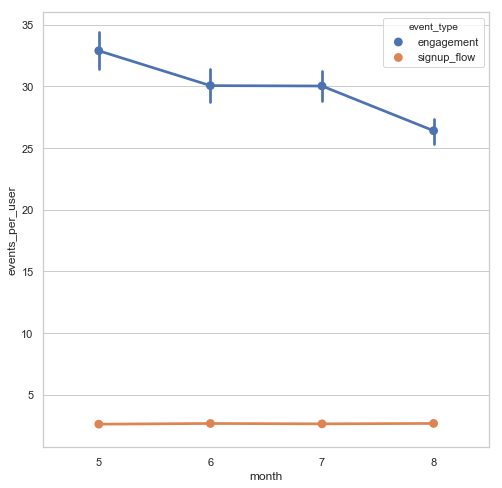

In [351]:
# What is event type and how does it change over time?
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (8, 8)
sns.pointplot(x="month", y="events_per_user", hue='event_type', data=events_per_user_by_time)

In [179]:
df_events['Week/Year'] = df_events['occurred_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
df_events['Week/Month'] = df_events['occurred_at'].apply(lambda x: "%d/%d" % (x.week, x.month))
df_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,year,month,week,Week/Year,Week/Month
0,10522,2014-05-02,engagement,login,Japan,dell inspiron notebook,3.0,2014,5,18,18/2014,18/5
1,10522,2014-05-02,engagement,home_page,Japan,dell inspiron notebook,3.0,2014,5,18,18/2014,18/5
2,10522,2014-05-02,engagement,like_message,Japan,dell inspiron notebook,3.0,2014,5,18,18/2014,18/5
3,10522,2014-05-02,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014,5,18,18/2014,18/5
4,10522,2014-05-02,engagement,search_run,Japan,dell inspiron notebook,3.0,2014,5,18,18/2014,18/5
